In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans
# import faiss 
import sys
sys.path.append("/ML_CW2/TorchSSL")
import numpy as np
import matplotlib.pyplot as plt
from TorchSSL.models.nets.wrn import build_WideResNet,  WideResNet
import TorchSSL.models.nets.wrn
print("WRN module file:", TorchSSL.models.nets.wrn.__file__)
import argparse

from TorchSSL.models.flexmatch.flexmatch import FlexMatch


WRN module file: c:\Users\chaso\OneDrive - King's College London\Documents\YR2 kcl\ML KCL\Everythin on ML CW2\ML_CW2\TorchSSL\models\nets\wrn.py


In [2]:
# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
 #                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False)
#print("hi")
#classes = ('plane', 'car', 'bird', 'cat',
 #          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
from resnet_cifar import resnet18

class SimCLRNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Use the CIFAR ResNet from your code snippet
        backbone_dict = resnet18(in_channel=3)
        self.backbone = backbone_dict['backbone']  # a ResNet instance
        backbone_dim  = backbone_dict['dim']       # should be 512
        print("backbone done")

        self.contrastive_head = nn.Sequential(
            nn.Linear(backbone_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)

        )

    def forward(self, x, return_features=False):
        feats = self.backbone(x)          # shape [bs, 512]
        proj  = self.contrastive_head(feats) # shape [bs, 128]
        if return_features:
            return proj, feats
        else:
            return proj


# Instantiate model
simclr_model = SimCLRNet ()  #features_dim=128

# Load the checkpoint
checkpoint_path = 'simclr_cifar-10.pth/simclr_cifar-10.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
print("checkpoint done")
simclr_model.load_state_dict(checkpoint, strict=False)  # or checkpoint['state_dict']
simclr_model.eval()
print("model lpoaded")
# Extract embeddings from the loaded model
# def extract_embeddings(model, dataset, device='cpu', batch_size=256):
    
#     loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
#     all_feats = []
#     model.to(device)
#     model.eval()
#     print("loop embed")
#     with torch.no_grad():
#         for imgs, _ in loader:
#             imgs = imgs.to(device)
#             # return_features=True  gets the encoder output
#             _, feats = model(imgs, return_features=True)
#             all_feats.append(feats.cpu().numpy())
#         #print(np.concatenate(all_feats, axis=0))
#     return np.concatenate(all_feats, axis=0)
# print("embeddding done")

# Now actually call the extraction function
#embeddings = extract_embeddings(simclr_model, trainset, device='cpu', batch_size=256)
#print("Embeddings shape:", embeddings.shape)


backbone done
checkpoint done
model lpoaded


In [4]:
def extract_embeddings(model, dataset, device='cpu', batch_size=256):
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_feats = []
    model.to(device)
    model.eval()
    print("loop embed")
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            # return_features=True  gets the encoder output
            _, feats = model(imgs, return_features=True)
            all_feats.append(feats.cpu().numpy())
        #print(np.concatenate(all_feats, axis=0))
    return np.concatenate(all_feats, axis=0)
print("embeddding done")


embeddding done


In [5]:
# Clustering
def cluster_embeddings(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    print("Cluster distribution:", dict(zip(unique_clusters, counts)))

    return cluster_labels
#cluster_labels = cluster_embeddings(embeddings, 10)

In [6]:
from sklearn.neighbors import NearestNeighbors

def compute_typicality_sklearn(embeddings, k=20):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    dist, _ = nbrs.kneighbors(embeddings)
    avg_dist = dist[:, 1:].mean(axis=1)
    return 1.0 / (avg_dist + 1e-8)
#typicality_vals = compute_typicality_sklearn(embeddings, k=20)

In [7]:
def select_typical_samples(embeddings, cluster_labels, B, typicality_vals):
    """
    Pick the most typical (highest density) sample in each of the B clusters.
    Paper: "We pick arg max_{x in cluster} typicality(x) for each cluster."
    """
    chosen_indices = []
    for cluster_id in range(B):
        cluster_idx = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_idx) == 0:
            continue
        cluster_tvals = typicality_vals[cluster_idx]
        best_local_idx = cluster_idx[np.argmax(cluster_tvals)]
        chosen_indices.append(best_local_idx)
    return chosen_indices


In [8]:
# # Initial pool selection
# def initial_pool_selection(model, unlabelled_indices, dataset, B=10, device='cpu'):
#     """
#     Implements Algorithm 1 from the paper for initial pool selection.
#     unlabelled_indices: list of indices in dataset that are unlabelled
#     B: number of points to query
#     Returns the selected indices for labeling.
#     """
#     # Extract embeddings for the unlabelled set
#     unlabelled_subset = Subset(dataset, unlabelled_indices)
#     embeddings = extract_embeddings(model, unlabelled_subset, device=device)

#     # Clustering (K-means with B clusters)
#     cluster_labels = cluster_embeddings(embeddings, B)

#     # For each cluster, picks the point with highest typicality
#     typicality_vals = compute_typicality_sklearn(embeddings, k=20)
#     local_chosen = select_typical_samples(embeddings, cluster_labels, B, typicality_vals)
#     # map from local indices to global dataset indices
#     chosen_global = [unlabelled_indices[loc] for loc in local_chosen]

#     return chosen_global

In [9]:
def query_selection(
    selection_mode,          # "random" or "tpcrp"
    embedding_mode,          # "fullysupervised" or "selfsupervised"
    unlabeled_indices,
    dataset,
    device='cpu',
    classifier=None,
    simclr_model=None,
    B=10
):
    """
    A universal function that picks new points to label,
    combining both the embedding choice (fully/self-supervised)
    and the selection strategy (random or TPC(RP)).
    """
    if selection_mode == 'random':
        # random ignores embeddings
        import numpy as np
        return list(np.random.choice(unlabeled_indices, size=B, replace=False))

    elif selection_mode == 'tpcrp':
        # TPC(RP) uses embeddings
        if embedding_mode == 'fullysupervised':
            assert classifier is not None
            unlabeled_subset = Subset(dataset, unlabeled_indices)
            embeddings = extract_embeddings(classifier, unlabeled_subset, device=device)
        elif embedding_mode == 'selfsupervised':
            assert simclr_model is not None
            unlabeled_subset = Subset(dataset, unlabeled_indices)
            embeddings = extract_embeddings(simclr_model, unlabeled_subset, device=device)
        elif embedding_mode == 'semisupervised':
            assert classifier is not None, "Need a semi-supervised (FlexMatch) model for embedding"
            # same approach as fullysupervised, but the 'classifier' is actually the semi-supervised model
            embeddings = extract_embeddings(classifier, unlabeled_subset, device=device)
        else:
            raise ValueError(f"Unknown embedding_mode: {embedding_mode}")

        # cluster
        cluster_labels = cluster_embeddings(embeddings, B)
        # typicality
        typicality_vals = compute_typicality_sklearn(embeddings, k=20)
        local_chosen = select_typical_samples(embeddings, cluster_labels, B, typicality_vals)
        chosen_global = [unlabeled_indices[loc] for loc in local_chosen]
        return chosen_global

    else:
        raise ValueError(f"Unknown selection_mode: {selection_mode}")


In [10]:
class SimpleClassifier(nn.Module):
    """
    A standard CNN or ResNet. For demonstration, a small net.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Flatten()
        )
        self.fc = nn.Linear(64*4*4, num_classes)

    def forward(self, x, return_features=False):
        feats = self.features(x)       # penultimate-layer features
        logits = self.fc(feats)        # final outputs
        if return_features:
            return logits, feats
        else:
            return logits

    


In [11]:
def train_supervised(model, dataset, labeled_indices, device='cpu', epochs=5, lr=1e-3, batch_size=64):
    """
    Trains 'model' on the subset of 'dataset' specified by labeled_indices.
    Paper: "We re-initialize the classifier each iteration" (Sec. 4.2).
    """
    subset = Subset(dataset, labeled_indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)
    model.train()
    for ep in range(epochs):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [12]:
def evaluate(model, test_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return 100.0 * correct / total

In [13]:
def random_selection(model, unlabelled_indices, dataset, B=10,  device='cpu'):
    return list(np.random.choice(unlabelled_indices, size=B, replace=False))

In [14]:
# # Example of how build_WideResNet might be defined
# def build_WideResNet(first_stride, depth, widen_factor, bn_momentum, leaky_slope, dropRate, use_embed, is_remix):
#     def build(num_classes):
#         # Define the WideResNet model here
#         model = WideResNet(
#             first_stride=first_stride,
#             depth=depth,
#             widen_factor=widen_factor,
#             #bn_momentum=bn_momentum,
#             #leaky_slope=leaky_slope,
#             num_classes=num_classes,
#             #dropRate=dropRate
#         )
#         return model
#     return build

In [24]:
class Args:
    def __init__(self):
        self.num_classes = 10
        self.num_train_iter = 20000
        self.num_eval_iter = 1000
        self.batch_size = 64
        self.uratio = 7  # ratio of unlabeled to labeled
        self.optim = 'SGD'
        self.lr = 0.03
        self.momentum = 0.9
        self.weight_decay = 5e-4
        self.ema_m = 0.999
        self.T = 0.5
        self.p_cutoff = 0.95
        self.ulb_loss_ratio = 1.0
        self.hard_label = True
        self.save_dir = './saved_models'
        self.save_name = 'flexmatch_cifar10'
        self.resume = False
        self.load_path = None
        self.amp = False
        self.dataset = 'cifar10'
        self.num_labels = 40
        self.gpu = 0

        

args = Args()


In [16]:
def my_wrn_net_builder(num_classes):
    """
    Returns a function that, when called with (num_classes),
    builds and returns a WideResNet.
    """
    #from TorchSSL.models.nets.wrn import build_WideResNet

    # Step A: create the builder object
    wrn_builder = build_WideResNet(
        first_stride=1,
        depth=28,
        widen_factor=2,
        bn_momentum=0.01,
        leaky_slope=0.1,
        dropRate=0.0,
        use_embed=False,
        is_remix=False
    )

    # Step B: Return the `.build` method
    # This is a callable that expects `num_classes` -> returns WideResNet
    model=wrn_builder.build(num_classes)
    return model


In [17]:
# def net_builder_fn(num_classes):
#     wrn_builder = build_WideResNet(
#         first_stride=1,
#         depth=28,
#         widen_factor=2,
#         bn_momentum=0.01,
#         leaky_slope=0.1,
#         dropRate=0.0,
#         use_embed=False,
#         is_remix=False     
#     )
#     model = wrn_builder.build(num_classes)
#     print(f"Model type: {type(model)}")  #
#     return model



In [18]:
# test_model = net_builder_fn(10)
# print(test_model)            # should show WideResNet structure
# for name, param in test_model.named_parameters():
#     print(name, param.shape) # verifies it's a real nn.Module


In [19]:
def train_flexmatch_one_round(
    labeled_indices,
    unlabeled_indices,
    trainset,
    test_loader,
    #net_builder_fn,
    args
): 
    """
    Trains a FlexMatch model for ONE active learning round,
    using the current labeled + unlabeled subsets.

    Args:
        labeled_indices (list): indices for the labeled subset
        unlabeled_indices (list): indices for the unlabeled subset
        trainset (Dataset): entire training dataset (CIFAR-10)
        test_loader (DataLoader): for evaluation
        net_builder_fn (callable): e.g. a function returning build_WideResNet(...).build(num_classes=10)
        args: an object/dict with needed fields:
            - num_classes, num_train_iter, num_eval_iter
            - T, p_cutoff, ulb_loss_ratio, hard_label, ema_m
            - save_dir, save_name
            - optim, lr, momentum, weight_decay
            - etc.

    Returns:
        (trained_model, eval_dict)
          trained_model: final FlexMatch model after .train(args)
          eval_dict: dictionary with final metrics (like 'eval/top-1-acc')
    """
    import torch
    from torch.utils.data import DataLoader, Subset
    from TorchSSL.train_utils import get_optimizer, get_cosine_schedule_with_warmup

    # 1) Build DataLoaders for labeled + unlabeled + test
    labeled_subset = Subset(trainset, labeled_indices)
    unlabeled_subset = Subset(trainset, unlabeled_indices)

    labeled_loader = DataLoader(labeled_subset, batch_size=args.batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=args.batch_size * args.uratio, shuffle=True)
    # test_loader is already built outside

    loader_dict = {
        'train_lb': labeled_loader,
        'train_ulb': unlabeled_loader,
        'eval': test_loader
    }

    # net_builder_fn = my_wrn_net_builder(
    #     first_stride=1,
    #     depth=28,
    #     widen_factor=2,
    #     bn_momentum=0.01,
    #     leaky_slope=0.1,
    #     dropRate=0.0,
    #     use_embed=False,
    #     is_remix=False
    # )

    # 2) net_builder => build the model
    # e.g. wrn_builder.build(num_classes=args.num_classes)
    # model_builder = net_builder_fn
    # 3) Instantiate FlexMatch
    flexmatch_obj = FlexMatch(
        net_builder=my_wrn_net_builder,  # e.g. lambda num_classes: wrn_builder.build(num_classes)
        num_classes=10, #args.num_classes,
        ema_m=args.ema_m,
        T=args.T,
        p_cutoff=args.p_cutoff,
        lambda_u=args.ulb_loss_ratio,
        hard_label=args.hard_label,
        it=0,
        num_eval_iter=args.num_eval_iter,
        tb_log=None,  # or pass a TBLog if you want
        logger=None
    )

    # 4) Set the data loader
    flexmatch_obj.set_data_loader(loader_dict)
    flexmatch_obj.set_dset(unlabeled_subset)

    # 5) Build optimizer & scheduler
    optimizer = get_optimizer(flexmatch_obj.model, args.optim, args.lr, args.momentum, args.weight_decay)
    scheduler = get_cosine_schedule_with_warmup(optimizer, args.num_train_iter)
    flexmatch_obj.set_optimizer(optimizer, scheduler)

    # 6) Actually train
    eval_dict = flexmatch_obj.train(args=args)

    # 7) The final model is in flexmatch_obj.model
    trained_model = flexmatch_obj.model

    return trained_model, eval_dict


In [20]:
def active_learning_loop_flexmatch(
    trainset,
    test_loader,
    my_wrn_net_builder,
    args,
    selection_mode='random',  # or 'tpcrp'
    initial_B=10,
    cycle_B=10,
    cycles=5
):
    """
    Active learning loop with semi-supervised FlexMatch.

    Args:
        trainset: entire CIFAR-10 dataset
        test_loader: for evaluation
        net_builder_fn: e.g. lambda num_classes: wrn_builder.build(num_classes)
        args: config for FlexMatch + training
        selection_mode: 'random' or 'tpcrp'
        initial_B: how many labels to pick initially
        cycle_B: how many to pick each round
        cycles: total AL cycles
    """
    unlabeled_indices = list(range(len(trainset)))
    labeled_indices = []

    # Step 1: pick initial_B points
    init_selection = query_selection(selection_mode='random',embedding_mode=None ,unlabeled_indices=unlabeled_indices,dataset=trainset,
    device="cpu", B=cycle_B)
    for idx in init_selection:
        unlabeled_indices.remove(idx)
        labeled_indices.append(idx)

    accuracies = []
    trained_model = None
    for cycle in range(cycles):
        # (A) Train FlexMatch for one round
        trained_model, eval_dict = train_flexmatch_one_round(
            labeled_indices,
            unlabeled_indices,
            trainset,
            test_loader,
            #my_wrn_net_builder,#net_builder_fn,
            args
        )

        # (B) Extract final accuracy from eval_dict
        acc = eval_dict.get('eval/top-1-acc', 0.0) * 100  # or however it's stored
        accuracies.append(acc)
        print(f"Cycle {cycle}: Accuracy {acc:.2f}% with {len(labeled_indices)} labels")

        # (C) Pick next cycle_B points
        new_selection = query_selection(selection_mode='tpcrp',embedding_mode='semisupervised',unlabeled_indices=unlabeled_indices,dataset=trainset,
    device="cpu",classifier=trained_model, B=cycle_B)
        for idx in new_selection:
            unlabeled_indices.remove(idx)
            labeled_indices.append(idx)

    # Plot
    plt.plot(range(len(accuracies)), accuracies, marker='o')
    plt.xlabel("Active Learning Cycle")
    plt.ylabel("Test Accuracy (%)")
    plt.title(f"FlexMatch AL - {selection_mode}")
    plt.show()

    return accuracies


In [25]:
# Run FlexMatch with TPC(RP) and self-supervised embeddings
accuracies = active_learning_loop_flexmatch(
    trainset,
    testloader,
    my_wrn_net_builder,
    args,
    selection_mode='tpcrp',
    initial_B=10,
    cycle_B=10,
    cycles=5
)

DEBUG in flexmatch.py: self.model type = <class 'TorchSSL.models.nets.wrn.WideResNet'>
[!] data loader keys: dict_keys(['train_lb', 'train_ulb', 'eval'])
DEBUG: net type is <class 'TorchSSL.models.nets.wrn.WideResNet'>


RuntimeError: Cannot access accelerator device when none is available.

In [13]:


# # Active learning loop
# def active_learning_loop(simclr_model, trainset, test_loader, initial_B=10, cycle_B=10, cycles=5, device='cpu'):
#     """
#     Integrates the initial selection + iterative queries.
   
#     """
#     # Start with no labeled data
#     all_indices = np.arange(len(trainset))
#     unlabelled_indices = list(range(len(trainset))) #list(all_indices)  # initially, everything is unlabelled
#     labeled_indices   = []

#     # Initial pool selection
#     init_selection = initial_pool_selection(simclr_model, unlabelled_indices, trainset, B=initial_B, device=device)
#     for idx in init_selection:
#         unlabelled_indices.remove(idx)
#         labeled_indices.append(idx)

#     print(f"Initial labelled set size = {len(labeled_indices)}")

#     # AL cycles
#     accuracies = []
#     for cycle in range(cycles):
#         # Train a supervised model from scratch using the labeled_indices
#         classifier = SimpleClassifier(num_classes=10)  
#         train_supervised(classifier, trainset, labeled_indices, device=device)
        
#         # Evaluate on test set
#         acc = evaluate(classifier, test_loader, device=device)
#         accuracies.append(acc)
#         print(f"Cycle {cycle}: Accuracy {acc:.2f}% with {len(labeled_indices)} labels")

#         # B. Query new points (reuse embeddings or recalc with your SimCLR model, etc.)
#         # For demonstration, let's do random here:
#         # but you'd do something like TPC-RP again (clustering the unlabelled, picking typical).
#         new_selection = initial_pool_selection(simclr_model, unlabelled_indices, trainset, B=cycle_B, device=device)
        
#         # Add them to labeled set
#         for idx in new_selection:
#             unlabelled_indices.remove(idx)
#             labeled_indices.append(idx)

#     plt.plot(range(len(accuracies)), accuracies, marker='o')
#     plt.xlabel("Active Learning Cycle")
#     plt.ylabel("Test Accuracy (%)")
#     plt.title("TPC(RP) Accuracy over AL Cycles")
#     plt.show()

#     print("Active learning finished.")
#     return accuracies

In [14]:
def active_learning_loop(
    trainset,
    test_loader,
    selection_mode,       # "random" or "tpcrp"
    embedding_mode,       # "fullysupervised" or "selfsupervised"
    simclr_model=None,    # used if embedding_mode='selfsupervised'
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
):
    unlabeled_indices = list(range(len(trainset)))
    labeled_indices = []

    # Possibly do an initial random pick if fullysupervised (0 labels => no embeddings)
    if embedding_mode == 'fullysupervised' and selection_mode=='tpcrp':
        # Start with a random seed so the classifier can learn something
        init_selection = query_selection("random", None, unlabeled_indices, trainset, B=initial_B)
    else:
        # Otherwise just do the chosen approach
        init_selection = query_selection(
            selection_mode,
            embedding_mode,
            unlabeled_indices,
            trainset,
            device=device,
            simclr_model=simclr_model,
            B=initial_B
        )

    for idx in init_selection:
        unlabeled_indices.remove(idx)
        labeled_indices.append(idx)

    print(f"Initial labelled set size = {len(labeled_indices)}")

    accuracies = []
    for cycle in range(cycles):
        # Train a new classifier from scratch each round
        classifier = SimpleClassifier(num_classes=10)
        train_supervised(classifier, trainset, labeled_indices, device=device)

        # Evaluate
        acc = evaluate(classifier, test_loader, device=device)
        accuracies.append(acc)
        print(f"Cycle {cycle}: Accuracy {acc:.2f}% with {len(labeled_indices)} labels")

        # Query next set of points
        new_selection = query_selection(
            selection_mode,
            embedding_mode,
            unlabeled_indices,
            trainset,
            device=device,
            classifier=classifier if embedding_mode=='fullysupervised' else None,
            simclr_model=simclr_model if embedding_mode=='selfsupervised' else None,
            B=cycle_B
        )

        # Add them
        for idx in new_selection:
            unlabeled_indices.remove(idx)
            labeled_indices.append(idx)

    # Plot
    plt.plot(range(len(accuracies)), accuracies, marker='o', label=f"{selection_mode}-{embedding_mode}")
    plt.xlabel("Active Learning Cycle")
    plt.ylabel("Test Accuracy (%)")
    plt.title(f"{selection_mode}-{embedding_mode} Accuracy over AL Cycles")
    plt.legend()
    plt.show()

    return accuracies


Initial labelled set size = 10
Cycle 0: Accuracy 11.94% with 10 labels
Cycle 1: Accuracy 12.53% with 20 labels
Cycle 2: Accuracy 10.09% with 30 labels
Cycle 3: Accuracy 10.32% with 40 labels
Cycle 4: Accuracy 10.57% with 50 labels


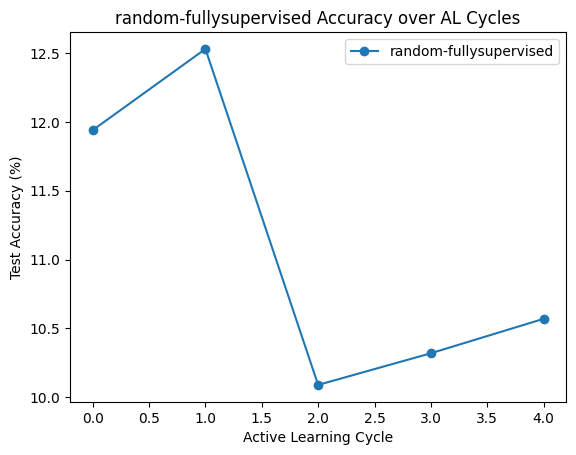

In [15]:
# Random and Fully supervised
acc_rand_fs = active_learning_loop(
    trainset,
    testloader,
    selection_mode='random',
    embedding_mode='fullysupervised',
    simclr_model=None,   # not needed
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
)

Initial labelled set size = 10
Cycle 0: Accuracy 13.53% with 10 labels
loop embed
Cluster distribution: {np.int32(0): np.int64(4218), np.int32(1): np.int64(8092), np.int32(2): np.int64(5312), np.int32(3): np.int64(5688), np.int32(4): np.int64(7888), np.int32(5): np.int64(4374), np.int32(6): np.int64(3608), np.int32(7): np.int64(2510), np.int32(8): np.int64(3705), np.int32(9): np.int64(4595)}
Cycle 1: Accuracy 14.15% with 20 labels
loop embed
Cluster distribution: {np.int32(0): np.int64(8396), np.int32(1): np.int64(3905), np.int32(2): np.int64(7327), np.int32(3): np.int64(2359), np.int32(4): np.int64(4454), np.int32(5): np.int64(5866), np.int32(6): np.int64(4728), np.int32(7): np.int64(4067), np.int32(8): np.int64(4333), np.int32(9): np.int64(4545)}
Cycle 2: Accuracy 14.21% with 30 labels
loop embed
Cluster distribution: {np.int32(0): np.int64(5316), np.int32(1): np.int64(6916), np.int32(2): np.int64(3601), np.int32(3): np.int64(4121), np.int32(4): np.int64(2511), np.int32(5): np.int64(

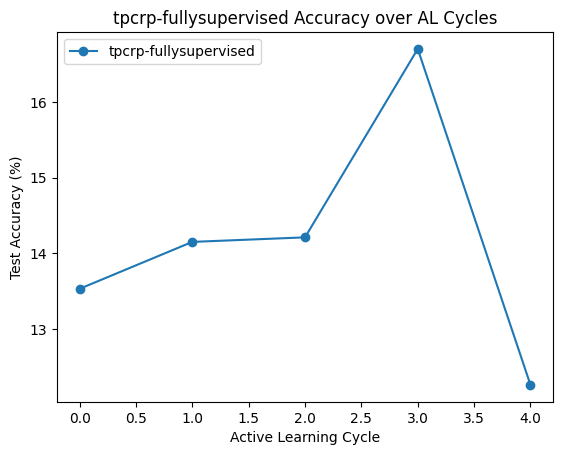

In [15]:
# 2) TPC(RP) + Fully Supervised
acc_tpcrp_fs = active_learning_loop(
    trainset,
    testloader,
    selection_mode='tpcrp',
    embedding_mode='fullysupervised',
    simclr_model=None,
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
)

Initial labelled set size = 10
Cycle 0: Accuracy 13.06% with 10 labels
Cycle 1: Accuracy 13.66% with 20 labels
Cycle 2: Accuracy 12.81% with 30 labels
Cycle 3: Accuracy 13.20% with 40 labels
Cycle 4: Accuracy 10.64% with 50 labels


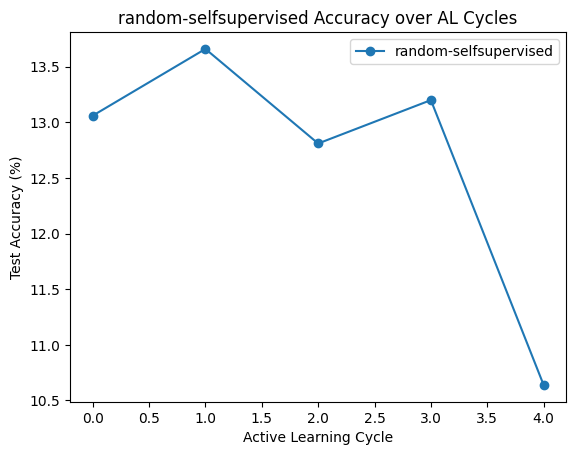

In [15]:
# 3) Random + Self-Supervised
acc_rand_ss = active_learning_loop(
    trainset,
    testloader,
    selection_mode='random',
    embedding_mode='selfsupervised',
    simclr_model=simclr_model,  # your pretrained SimCLR
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
)

loop embed
Cluster distribution: {np.int32(0): np.int64(9727), np.int32(1): np.int64(2673), np.int32(2): np.int64(1776), np.int32(3): np.int64(3459), np.int32(4): np.int64(3596), np.int32(5): np.int64(5340), np.int32(6): np.int64(16743), np.int32(7): np.int64(3365), np.int32(8): np.int64(583), np.int32(9): np.int64(2738)}
Initial labelled set size = 10
Cycle 0: Accuracy 11.51% with 10 labels
loop embed
Cluster distribution: {np.int32(0): np.int64(2890), np.int32(1): np.int64(1766), np.int32(2): np.int64(2774), np.int32(3): np.int64(3635), np.int32(4): np.int64(9145), np.int32(5): np.int64(16483), np.int32(6): np.int64(3376), np.int32(7): np.int64(1300), np.int32(8): np.int64(5169), np.int32(9): np.int64(3452)}
Cycle 1: Accuracy 12.26% with 20 labels
loop embed
Cluster distribution: {np.int32(0): np.int64(3045), np.int32(1): np.int64(5195), np.int32(2): np.int64(3866), np.int32(3): np.int64(3625), np.int32(4): np.int64(1288), np.int32(5): np.int64(1771), np.int32(6): np.int64(3435), np.

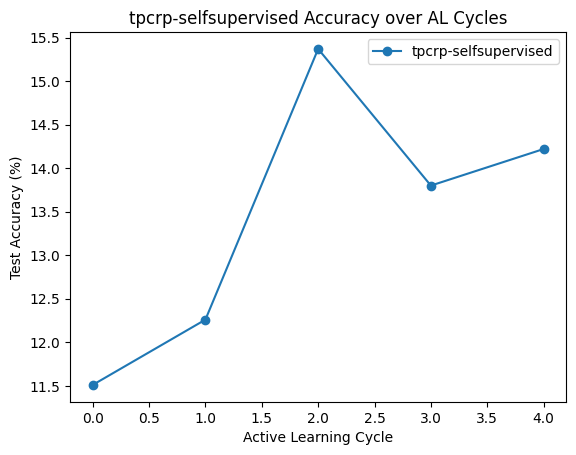

In [15]:
# 4) TPC(RP) + Self-Supervised
acc_tpcrp_ss = active_learning_loop(
    trainset,
    testloader,
    selection_mode='tpcrp',
    embedding_mode='selfsupervised',
    simclr_model=simclr_model,
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
)

Initial labelled set size = 10
Cycle 0: Accuracy 11.13% with 10 labels
Cycle 1: Accuracy 10.73% with 20 labels
Cycle 2: Accuracy 13.61% with 30 labels
Cycle 3: Accuracy 13.58% with 40 labels
Cycle 4: Accuracy 13.91% with 50 labels


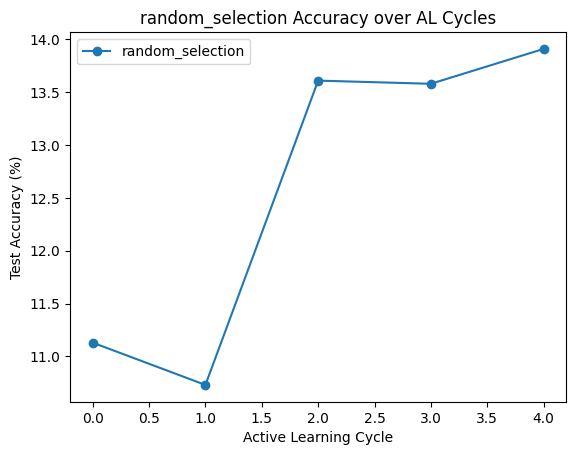

Active learning finished.


In [14]:
final_acc_random = active_learning_loop(
    selection_fn=random_selection,
    simclr_model=simclr_model,   # not used by random_selection
    trainset=trainset,
    test_loader=testloader,
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
)

loop embed
[[0.00000000e+00 8.47347826e-02 3.77072534e-03 ... 2.00939290e-02
  1.05962390e-04 9.65099782e-04]
 [3.60262394e-01 0.00000000e+00 4.41906834e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.68195423e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.35578960e-01]
 ...
 [2.38247126e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.07215417e-02 6.63895160e-04]
 [1.91189289e-01 2.39160322e-02 0.00000000e+00 ... 6.64417725e-03
  1.11479454e-01 3.61148715e-02]
 [9.94993299e-02 0.00000000e+00 2.65486538e-02 ... 0.00000000e+00
  1.76693453e-03 0.00000000e+00]]
Cluster distribution: {np.int32(0): np.int64(9727), np.int32(1): np.int64(2673), np.int32(2): np.int64(1776), np.int32(3): np.int64(3459), np.int32(4): np.int64(3596), np.int32(5): np.int64(5340), np.int32(6): np.int64(16743), np.int32(7): np.int64(3365), np.int32(8): np.int64(583), np.int32(9): np.int64(2738)}
Initial labelled set size = 10
Cycle 0: Accuracy 12.73% with 10 labels
loop 

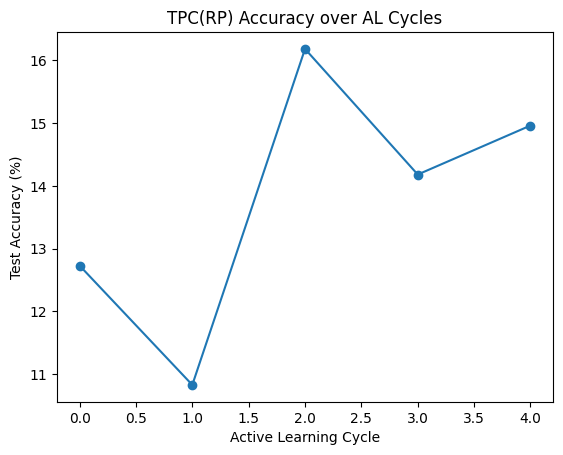

Active learning finished.


In [65]:
final_accuracies = active_learning_loop(
    simclr_model,
    trainset,
    testloader,
    initial_B=10,   # how many labels to pick initially
    cycle_B=10,     # how many labels to pick each cycle
    cycles=5,       # total number of AL cycles
    device='cpu'
)

loop embed


TypeError: 'int' object is not subscriptable